In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import cuda_cmm, math, hashlib

In [3]:
mu = 0.1
delta = 1e-3
cToC = 0.3
L = 1.0
sigma = 0.1
beta_naught = math.pi / 180.0 * 23 / 2

config_string = "{}-{}-{}-{}-{}-{}".format(mu, delta, cToC, L, sigma, beta_naught)
config_hash = hashlib.sha1(bytes(config_string, 'ascii')).hexdigest()

config_root = "./config/"

In [4]:
print("\nMagnetite Data Generation")
# float fr = vec[5 * i + 0];
# float A = vec[5 * i + 1];
# float tau = vec[5 * i + 2];

num_frs = 2<<6
num_As = 2<<4
num_taus = 2<<4

frs = np.linspace(-1.1, 1.1, num_frs, dtype=np.float32)
As = np.linspace(-50, 50, num_As, dtype=np.float32)
taus = np.linspace(0.5, 2.0, num_taus, dtype=np.float32)

num_combos = num_frs*num_As*num_taus
print("num_combos:", num_combos)


vec = np.zeros((num_combos, 6), dtype=np.float32)

# print("Starting Vector loading")

for i, fr in enumerate(frs):
    for j, A in enumerate(As):
        for k, tau in enumerate(taus):
            ind = i * num_As * num_taus + j * num_taus  + k
            vec[ind, 0:3] = [fr, A, tau]

print("Starting Cuda")
cuda_cmm.c_coefficient(vec, beta_naught, mu, delta, cToC, L, sigma)
# float beta_naught, float mu, float delta, float cToC, float L, float sigma

print("\nCuda Done")

np.save("{}cmm_magnetite-{}.npy".format(config_root, config_hash), vec)


Magnetite Data Generation
num_combos: 131072
Starting Cuda

Cuda Done


In [5]:
mag_data = np.load("./config/cmm_magnetite-14a74e2aee00afbe6f8abe84a2d384a85172ac8c.npy")

In [6]:
mag_data[:, 0]

array([-1.1035278 ,  0.20931724, -1.1643772 , ...,  1.0999917 ,
        1.1000046 ,  1.0999959 ], dtype=float32)

In [7]:
mag_frame = pd.DataFrame(mag_data)
mag_frame.columns = ["fr", "A", "tau", "clamp_ratio", "tau_effec", "dim_clamp_prim"]

In [8]:
mag_frame.describe()

,fr,A,tau,clamp_ratio,tau_effec,dim_clamp_prim
count,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000
mean,-0.084825,-9.536743e-07,1.250000,0.102570,-1.606298,13.197163
std,0.882673,2.978428e+01,0.446764,1.274705,10.514007,9.665456
min,-1.535830,-5.000000e+01,0.500000,-1.900113,-52.156643,3.499313
25%,-1.147797,-2.500000e+01,0.875000,-1.125999,0.628936,5.205296
50%,0.251202,0.000000e+00,1.250000,0.181777,1.050817,8.606244
75%,0.550005,2.500000e+01,1.625000,1.346077,1.669016,23.087286
max,1.100007,5.000000e+01,2.000000,1.958864,8.554693,36.041561


In [9]:
np.isfinite(mag_frame).all()

fr                True
A                 True
tau               True
clamp_ratio       True
tau_effec         True
dim_clamp_prim    True
dtype: bool

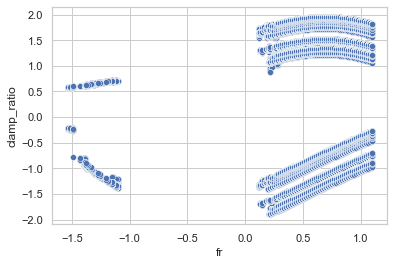

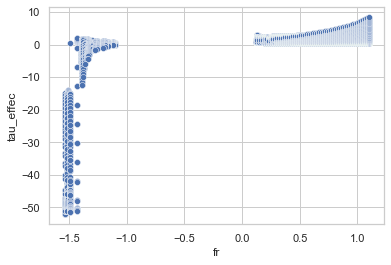

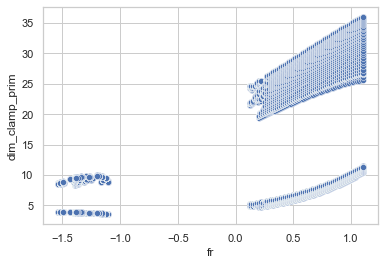

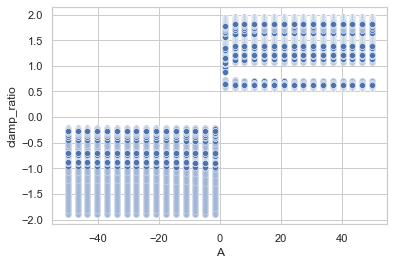

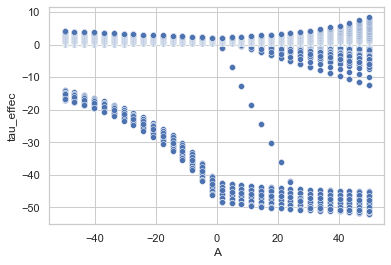

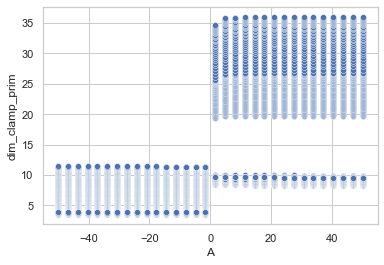

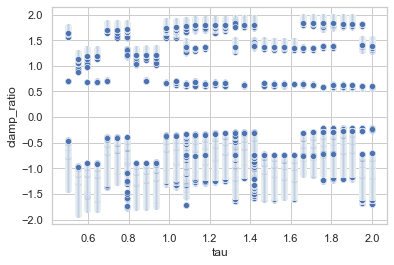

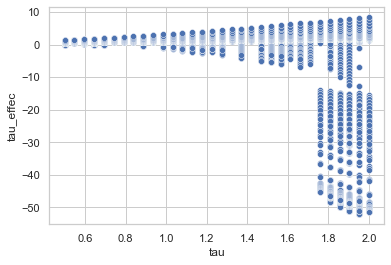

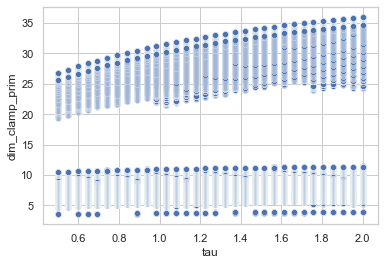

In [10]:
sns.set(style='whitegrid')
for input in ("fr", "A", "tau"):
    for output in ("clamp_ratio", "tau_effec", "dim_clamp_prim"):
        sns.scatterplot(x=input, y=output, data=mag_frame)
        plt.show()
# sns.scatterplot(x="A", y="dim_clamp_prim", data=mag_frame)

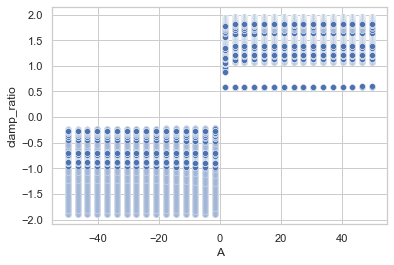

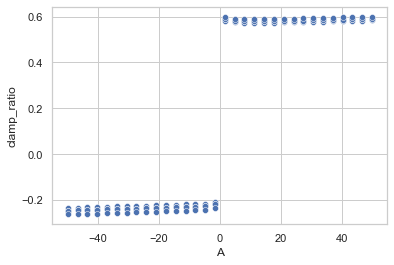

In [11]:
sns.scatterplot(x="A", y="clamp_ratio", data=mag_frame[(mag_frame["fr"] > 0) | (mag_frame["fr"] <= 0) & (mag_frame["tau"] == 2.0)])
plt.show()
sns.scatterplot(x="A", y="clamp_ratio", data=mag_frame[(mag_frame["fr"] < 0) & (mag_frame["tau"] == 2.0)])
plt.show()

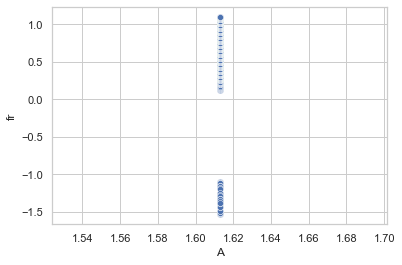

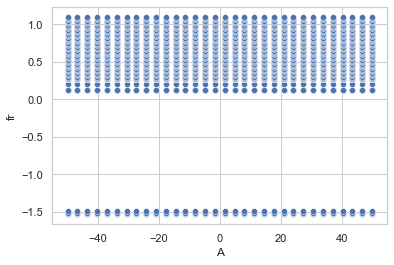

In [12]:
sns.scatterplot(x="A", y="fr", data=mag_frame[(mag_frame["A"] > 0) & (mag_frame["A"] < 2)])
plt.show()
sns.scatterplot(x="A", y="fr", data=mag_frame[mag_frame["tau"] == 2.0])
plt.show()